**Installing libraries that are necessary to run this notebook on google colaboratory**

In this work, we take a closer look into the result of the model with the best validation metrics. We load the data and the checkpoint of the model from google drive.  

In [1]:
!pip install -q transformers
!pip install sentencepiece
!pip install langdetect

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 61.7 MB/s 
     |████████████████████████████████| 596 kB 52.5 MB/s 
     |████████████████████████████████| 895 kB 58.6 MB/s 
     |████████████████████████████████| 61 kB 583 kB/s 
     |████████████████████████████████| 1.2 MB 5.4 MB/s 
     |████████████████████████████████| 981 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=b29964d2efa56f14a37db561708a256ac5f436dba0727f8a8d45d4136ee2afe4
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [1]:
import transformers
import torch
from torch.utils.data import DataLoader
from torch import cuda

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
from langdetect import detect



We mount the drive to google colaboratory. If you want to run the notebook locally, you need to have a folder *my_folder* that contains a folder *Data* with a train.csv file. In this case you only need to be sure that you are in the folder *my_folder* by running the commented command and deleted the rest of the code in the next cell. 


In [3]:
#os.chdir('path/my_folder')
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/MyDrive/Synthesio')

Mounted at /content/drive


## Reading and preparing the data

In [4]:
df = pd.read_csv('Data/train.csv')
df = df[df['sentiment'] != 'unassigned']
categories_encoding = {'negative': 0, 'neutral':1, 'positive':2 }
df['sentiment'] = df['sentiment'].replace(categories_encoding)

## Importing and loading the best model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.load_state_dict(torch.load('best_model_xlmr_tweets_fine_tuned.pth',
                                     map_location=torch.device(device)))
model.to(device)

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

<All keys matched successfully>

## Creating validation dataloader

In [6]:
def create_dataset(data, tokenizer, max_length=512):

  X_train, X_val, Y_train, Y_val = train_test_split(list(data['content']), 
                                                      data['sentiment'],
                                                      test_size=0.2,
                                                      random_state=42)
  
  Y_train.index = range(len(Y_train))
  Y_val.index = range(len(Y_val))
  train_encodings = tokenizer(X_train,
                              truncation=True,
                              padding=True, 
                              max_length=max_length)
  val_encodings = tokenizer(X_val,
                            truncation=True,
                            padding=True,
                            max_length=max_length)

  return train_encodings, np.array(Y_train), val_encodings, np.array(Y_val)


class Sentiment_analysis_dataset(torch.utils.data.Dataset):

  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  
  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item
  
  def __len__(self):
    return len(self.labels)

test_params = {'batch_size': 4,
              'shuffle': False,
              'num_workers': 0
              }   
train, y_train, val, y_val = create_dataset(df, tokenizer)
val_dataset = Sentiment_analysis_dataset(val, y_val)
val_loader = DataLoader(val_dataset, **test_params)

## Generating output on the validation dataset

In [11]:
final_outputs=[]
softmax = torch.nn.Softmax(dim=1)

for batch in val_loader:
  input_ids = batch['input_ids'].to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
  labels = batch['labels'].to(device, dtype = torch.long)
  outputs = model(input_ids, attention_mask)
  final_outputs.extend(softmax(outputs.logits).cpu().detach().numpy().tolist())


**Confusion matrix**

We dig into the confusion between the different class by looking into the confusion matrix that we normalize according to the true labels.

Text(0.5, 1.0, "Confusion matrix of the model 'xlm_tweets fine-tuned'")

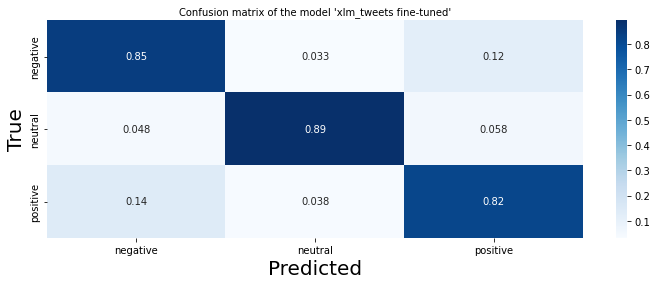

In [12]:
y_pred  = np.argmax(final_outputs, axis=1)
fig, axes = plt.subplots( figsize=(12, 4))
conf_mat = metrics.confusion_matrix(y_val, y_pred, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="Blues",
            xticklabels =['negative', 'neutral', 'positive'],
            yticklabels = ['negative', 'neutral', 'positive'], ax=axes)
plt.ylabel('True',  fontsize=20)
plt.xlabel('Predicted' ,fontsize=20)
axes.set_title("Confusion matrix of the model 'xlm_tweets fine-tuned'",
                  size=10)
# confusion matrix normalize % true 




*  The model more error by attributing negative labels to positive examples and positive label to negative examples that by confusing the neural examples with the non-neutral ones.

--> Next we will take a look into some examples of this confusion

**Analysing errors**

In this part, we will be looking deeper into the examples that were misclassified and specially the confusion between negative and positive examples. I looked at different examples and I noticed that the miss-classification is due to three reasons:


1.   annotation errors
2.   confusing contents where one part of the text express positive sentiment and the rest express the contrary.
3. misunderstanding the text: the model misclassify the text because it doesn't "understand" it

In [13]:
_, val_text, _, _ = train_test_split(list(df['content']), 
                                      df['sentiment'],
                                      test_size=0.2,
                                      random_state=42)

In [14]:
true_pos_pred_neg = np.array(val_text)[np.where((y_pred==0) & (y_val==2))]
true_neg_pred_pos = np.array(val_text)[np.where((y_pred==2) & (y_val==0))]

Here are some examples of **positive examples that were classified as negatives**: <br>

---


1. **Annotation errors**:
---

*   true_pos_pred_neg[190]: "*sy kecewa krn barang nya tdk sebagus yg ada d gambar jahitan nya jg jelek bgt*" -> Traduction: "*I'm disappointed because the item is not as good as the one in the picture, the stitching is also very bad*"

*   true_pos_pred_neg[198]: "*Trop de fautes d'orthographe inacceptables malgré un suspense certain. Thriller bien ficelé. Une médium attachante, 2 copines courageuses, des flics sympas, et les 2 immondes à la limite personnages de BD. Ça se lit vite ( vite ne prend jamais de S, mais tapis en a 1.)*"

---

2. **Confusing contents**
---


*    true_pos_pred_neg[10]: "*جميل لكن اللون باهت نوعا ما*" -> Traduction: "*Beautiful but the color is a bit faded*" --> The confusion comes from the fact that the text contains two opinions the first is positive and the second is negative, but in this case we can say that the overall sentiment is negative since no one is interesting in buying a product after seeing this comment.
---

3. **Misunderstanding** 

---

*   true_pos_pred_neg[131]: *'rien a signalé objet comforme a la description'* --> the text is obviously positive, but it is classified as negative. This misclassification may be caused by the miss understanding of the word *signalé* which was misspelled.
*   true_pos_pred_neg[165]: *'جامدة موت'* and true_pos_pred_neg[118]:فشخ --> those two examples are written in the Egyptian dialect which is not a language used in the pre-training of the language model so the model handle them as Arabic text. However, these two expressions don't have the same meaning in Arabic and in the Egyptian dialect. While they mean respectively *"rigid death"* and "break up" in Arabic, they are used in the Egyptian dialect to say "very good".




Here are some examples of **negative examples that were classified as positives**: <br>

---

1.   **Annotation errors:** 
---

* true_neg_pred_pos[3]: "*I took in 52 hardbound books by James Patterson and Lee Child that were in very good to excellent condition and was paid 27 cents per book. Yes, 27 cents per book.*" --> which is clearly a positive example
* true_neg_pred_pos[59]:  *"اشكركم على هذا البرنامج جدا مفيد ؟"* --> Traduction: Thank you for this very useful program?

---

2.   **Confusing contents**
---

* tue_neg_pred_pos[90]: "*Très bonne odeur mais n hydrate pas beaucoup. Aide à démêler mais c est tout"* --> This text contains an expression that encodes the positive idea of a good smell and another expression that encodes a negative one of a product that doesn't hydrate.
* tue_neg_pred_pos[19]: "*The game looks aswsome and is probably fun to play,but at what cost? I downloaded This on my kindle,only to find out that it takes up over that majority of my kindle space! Buying this app is your decision to make,but keep in mind you'll suffer the loss of a lot of space. Hope this review helped!*"
---

3. **Miss understanding**
---

* tue_neg_pred_pos[70]! *"Duper"*
* tue_neg_pred_pos[122]: *"j'ai commandé 3 multiprises à interrupteur, aucun interrupteur ne fonctionne... aucun des 3 ! c'est juste incroyable.... les prises fonctionnent bien par ailleurs... mais sans les lumières sur les inter."* --> this example is obvously a negative one, but was classified as a positive. The presence of the word "incroyable" maybe the cause of this misclassification.

---



**Performances per language**

Next we will take a look into the performances of the model per language to see if it performs better on certain languages than on others. 
We start by plotting bars that represent the accuracy of the model on each language when evaluated on the evaluation dataset. As we can see in the next plot that the accuracy varies heavily.
By intuition we can say that the models will perform better with languages that are frequent in the training data. That's why we plot next to the accuracy bars, the number of occurrences of each language in the training set. We normalize this number while dividing it by the number of occurrences of the most frequent language in the train dataset.<br>
We only plot the 20 most frequent languages for visual clarity.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


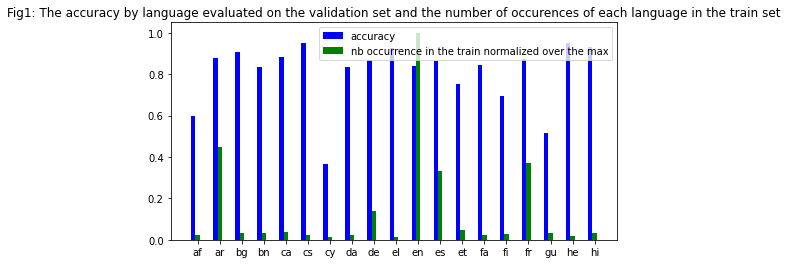

In [23]:
def detect_language(x):
    try :
        return detect(x)
    except :
        return 'Others'
languages = df['content'].apply(detect_language)
train_languages, val_languages, _, _ = train_test_split(languages, 
                                                      df['sentiment'],
                                                      test_size=0.2,
                                                      random_state=42)
                                                      
lang_in_train = pd.Series(train_languages).value_counts()
results_per_language = pd.DataFrame([val_languages.values,
                                     (np.array(y_pred) == np.array(y_val)).tolist()])\
                       .T.rename(columns={0:'language', 1:"result"})\
                       .groupby('language').agg({'result':['sum','count']})

results_per_language['accuracy_per_lan'] = results_per_language[('result',   'sum')]/results_per_language[('result', 'count')]
results_per_language = results_per_language.join(lang_in_train)
results_per_language = results_per_language.rename(columns={('accuracy_per_lan', ''):"accuracy", 'content': 'nb_occurrence_in_train'}).drop([('result', 'sum'),	('result', 'count')], axis =1)
x_axis = np.arange(len(results_per_language))[1:20]
y = results_per_language['accuracy'].values[1:20]
z = results_per_language['nb_occurrence_in_train'].values[1:20]/max(results_per_language['nb_occurrence_in_train'])
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x_axis-0.2, y, width=0.2, color='b', align='center', label ='accuracy')
ax.bar(x_axis, z, width=0.2, color='g', align='center', label ='nb occurrence in the train normalized over the max')
plt.xticks(x_axis, results_per_language.index[1:20])
plt.title('Fig1: The accuracy by language evaluated on the validation set and the number of occurences of each language in the train set')
ax.legend(loc='upper right')

plt.show()

In [28]:
from scipy.stats import pearsonr
corr, _ = pearsonr(results_per_language['accuracy'].values, results_per_language['nb_occurrence_in_train'])
print("The correlation between the language's number of occurrence and the its accuracy is {}".format(corr))

The correlation between the language's number of occurrence and the its accuracy is 0.2470160287416774


We can see in the previous plot that some languages perform better than other languages that are more frequent in the train dataset --> there is no obvious correlation between the number of occurrences and the accuracy of the model with a language. This can be confirmed by the correlation calculation.<br>

In fact, this is not surprising since the multilingual language models are know to be able to learn the task (the text classification for sentiment analysis in this case) in a language and then genralize it to other languages that where present in the pre-training corpus. So during fine-tuning, the model is not learning the task in a particular language only throw the examples in that language but throw all the examples.<br>

In order to explain the variation in the accuracy of the model per language we will take a look at the composition of the corpora used to pre-train the language model. We remind that the model was pre-trained in two parts:
1. xlm-r pre-pretraining on the CommonCrawl-100 multilingual corpus 
2. XLM-Twitter pre-training on a corpus containing 198M tweets.<br>
Next, we will look at those corpora.
In the fig1, we can see that the model performances better on Hebrew (language code he) than on Gujarati (language code gu) even if those both languages have a close number of occurrences. When we look into the pre-training corpora composition, this make sens: the Hebrew dataset is 10 times greater than Gujarati's. This also explain how results on Greek (language code el) is better than results on Gujarati even if Greek is less present in our training dataset.

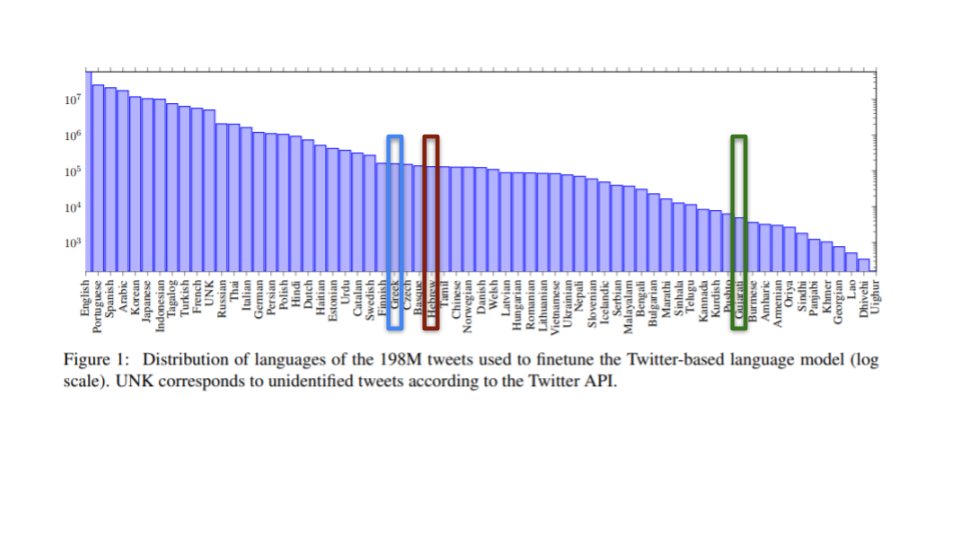

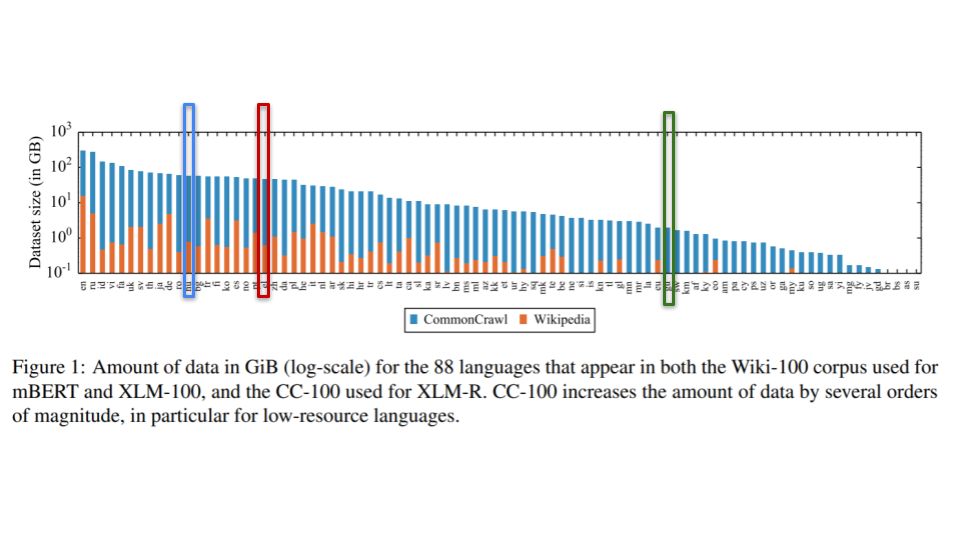